In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl

import am_sim as ams

### Load parameters

In [2]:
# load search df
df = pd.read_csv('inference_results/t_final_search_history.csv', index_col=0)

# load best parameters set from search dataframe
from utilities.analyze_inference import best_par_in_df
par = best_par_in_df(df)

### Simulate stochastic model keeping trace of the clonal families

In [3]:
from utilities.clonotype_analysis import stoch_GC_clonotype_evo, plot_GC_ctype_evo

N_sims = 1000 # number of stochastic simulations
D_test = 1. # injected Ag dosage
T_test = 28 # number of days of evolution

processing simulation 1 / 1000


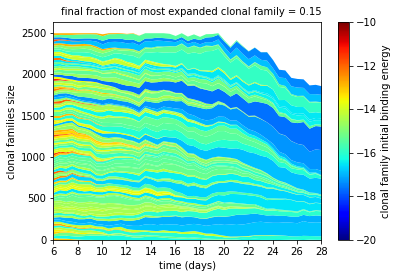

processing simulation 101 / 1000
processing simulation 201 / 1000
processing simulation 301 / 1000
processing simulation 401 / 1000
processing simulation 501 / 1000
processing simulation 601 / 1000


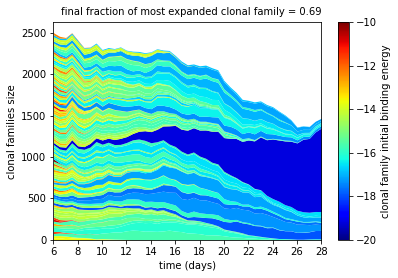

processing simulation 701 / 1000
processing simulation 801 / 1000
processing simulation 901 / 1000


In [14]:
# execute stochastic simulations and produce figures for the two dominance exaples
# NB: if the simulations are too long the results can be directly loaded executing the next cell

sim_results = [] # list of simulation results

for n_seed in range(N_sims):
    
    # print every 100 simulations
    if n_seed % 100 == 0:
        print(f'processing simulation {n_seed + 1} / {N_sims}')
    
    # for reproducibility of the two examples 
    np.random.seed(n_seed)
    
    # perform a stochastic simulation, returns
    # the evolution of the number of members for each clonal family over time,
    # and the initial binding energy of each clonal family,
    ctype_count_df, founders_en = stoch_GC_clonotype_evo(par, D_test, T_test)
    # extract time in days relative to the clonal counts
    t_days = ctype_count_df.index
    # extract frequency of most expanded clonal family for each time
    f_max = ctype_count_df.max(axis=1) / ctype_count_df.sum(axis=1)
    
    # create a dictionary entry to append to the results.
    # it contains the evolution of the must abundant clonotype frequency
    df_entry = {f'fmax_t_{t_days[n]}' : fm for n, fm in enumerate(f_max)}
    # the initial binding energy of the highest-affinity clonotype
    df_entry['best_founder_en'] = founders_en.min()
    # the seed that produced the simulation
    df_entry['seed'] = n_seed
    # append the result to the result list
    sim_results.append(df_entry)
    
    # plot two examples for two particular seeds (low and high clonal dominance) for figure 3
    if n_seed == 74:
        fig, ax = plt.subplots(1,1)
        mapp = plot_GC_ctype_evo(ax, ctype_count_df, founders_en, cmap_range=[-20,-10])
        plt.colorbar(mapp, label='clonal family initial binding energy')
        plt.savefig('figures/fig_3/low_clonal_dominance_example.pdf')
        plt.show()
    elif n_seed == 666:
        fig, ax = plt.subplots(1,1)
        mapp = plot_GC_ctype_evo(ax, ctype_count_df, founders_en, cmap_range=[-20,-10])
        plt.colorbar(mapp, label='clonal family initial binding energy')
        plt.savefig('figures/fig_3/high_clonal_dominance_example.pdf')
        plt.show()
        
    
# create dataframe with the results
results_df = pd.DataFrame(sim_results)
results_df = results_df.set_index('seed')

# save simulation results in a pickle archive
with open('figures/fig_3/stoch_sim_results.pkl', 'wb') as f:
    pkl.dump(results_df, f)
    f.close()

In [5]:
# if the stochastic simulations are too long one can simply load the results from the archive
with open('figures/fig_3/stoch_sim_results.pkl', 'rb') as f:
    results_df = pkl.load(f)
    f.close()

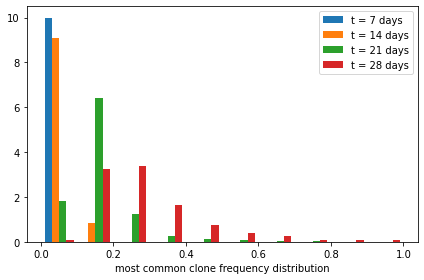

In [6]:
# time-points in days in which to histogram the frequency
t_hist = [7., 14., 21., 28.]
# frequency-space bins
bins = np.linspace(0,1,11)

# list of frequencies at the desired time-points
freq_mat = results_df[[f'fmax_t_{th}' for th in t_hist]].to_numpy()

# plot the histogram of the frequencies
plt.hist(freq_mat, bins=bins, density=True, label = [f't = {int(th)} days' for th in t_hist])
plt.xlabel('most common clone frequency distribution')
plt.legend()
plt.tight_layout()
plt.savefig('figures/fig_3/freq_distribution.pdf')
plt.show()

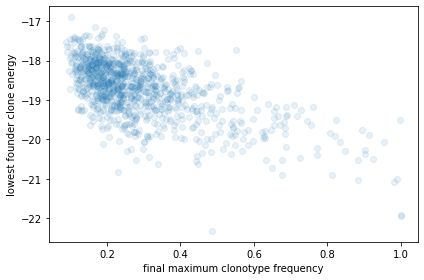

In [7]:
# list frequencies of must abundant clonotype at day 28
freq_final = results_df['fmax_t_28.0']
# initial energy of the highest-affinity clone
best_en = results_df['best_founder_en']

# scatter-plot freq. vs initial highest energy
plt.scatter(freq_final, best_en, alpha=0.1)
plt.ylabel('lowest founder clone energy')
plt.xlabel('final maximum clonotype frequency')
plt.tight_layout()
plt.savefig('figures/fig_3/scatter_freq_vs_dominance.pdf')
plt.show()

### Plot figure 3 panel

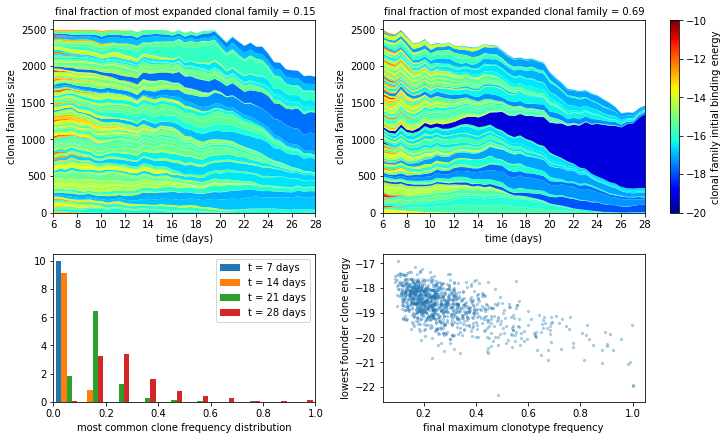

In [15]:
# Global figure setup
fig, ax = plt.subplots(2,2, figsize=(10,6), gridspec_kw={'height_ratios': [1.3, 1]}, constrained_layout=True)

# low clonal dominance example
np.random.seed(74)
ctype_evo_df, ctype_en = stoch_GC_clonotype_evo(par, D_test, T_test)
plot_GC_ctype_evo(ax[0,0], ctype_evo_df, ctype_en, cmap_range=[-20,-10])

# high clonal dominance example
np.random.seed(666)
ctype_evo_df, ctype_en = stoch_GC_clonotype_evo(par, D_test, T_test)
mapp = plot_GC_ctype_evo(ax[0,1], ctype_evo_df, ctype_en, cmap_range=[-20,-10])

# colorbar
plt.colorbar(mapp, ax=ax[0,:], label='clonal family initial binding energy', aspect=35.)

# frequency histogram
ax[1,0].hist(freq_mat, bins=bins, density=True, label = [f't = {int(th)} days' for th in t_hist])
ax[1,0].set_xlabel('most common clone frequency distribution')
ax[1,0].set_xlim(0,1)
ax[1,0].legend()

# scatter plot
ax[1,1].scatter(freq_final, best_en, alpha=0.3, s=5.)
ax[1,1].set_ylabel('lowest founder clone energy')
ax[1,1].set_xlabel('final maximum clonotype frequency')

# save gigure and show
plt.savefig('figures/fig_3/fig_3.pdf')
plt.show()